# Script to generate routes between fed locations

Code inspired from https://ipython-books.github.io/147-creating-a-route-planner-for-a-road-network/

Data(.shp file) from https://mapcruzin.com/free-delhi-country-city-place-gis-shapefiles.htm

In [1]:
import io
import os
import zipfile
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Geocoding')
sys.path.insert(2, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Range')

In [3]:
def unzip_file(name):
  zipped_file = name
  zip_ref = zipfile.ZipFile(zipped_file, 'r')
  zip_ref.extractall('.')
  zip_ref.close()

In [4]:
unzip_file('delhi_highway.zip')

In [5]:
import gdal
g = nx.read_shp('delhi_highway.shp')

In [6]:
# Requires a lot of space, graph too big

# nx.draw(g)
# plt.show()

In [7]:
# Graph might not be connected, this function will yield the largest connected subgraph.
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

sgs = list(connected_component_subgraphs(g.to_undirected())) # sgs is a list of subgraphs

i = np.argmax([len(sg) for sg in sgs]) # i holds the location of the largest connected subgraph
# print(i)
sg = sgs[i] # sg is the subgraph of interest

# print(len(sg)) # number of nodes in this subgraph

In [100]:
from GeocodeAddress import geocoding
print("Enter source: ")
address = input()
pos0 = geocoding(address)
print("Enter destination: ")
address = input()
pos1 = geocoding(address)

Enter source: 
Indira Gandhi International Airport, Delhi, India
Enter destination: 
Noida, India


In [101]:
print("Source entered: ", pos0)
print("Destination entered: ", pos1)

Source entered:  (28.55489735, 77.08467458266915)
Destination entered:  (28.5726442, 77.3547609)


In [102]:
def get_path(n0, n1): # n0 and n1 are tuples(containing the latitude and longitude) of the 2 locations
# returns points linking the 2 given locations
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [103]:
radius = 6372.8
def calcDist(lat0, lon0, lat1, lon1):
    # calculates and returns the Great-Circle Distance using the cosine formula****(in km)****
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    
    return radius*c

In [104]:
# leverages the calcDist function to calculate the length between given 2 points
def get_path_length(path):
    return np.sum(calcDist(path[1:, 1], path[1:, 0], path[:-1, 1], path[:-1, 0])) # pass the lat and lon of the 2 points

Get Charging Stations from csv

In [105]:
df = pd.read_csv('ModifiedStations.csv')
df['location'] = list(zip(df.LATITUDE, df.LONGITUDE))

In [106]:
stations = []
for station in df.location:
    stations.append(station)
    
stations = np.array(stations) # Convert list to numpy array
    
stations = stations[:, ::-1]  # Flip the tuple from (lat, lon) to (lon, lat)
# print(stations)

station_set = set()
for val in stations:
    val = val.tolist()
    val = tuple(val)
    station_set.add(val)
    
# print(station_set)  # Set of locations of the charging stations stored as tuples.(lon, lat)

In [107]:
# Get charging station closest to the source
sourceDistToStation = 1e10
# Store the location of the station closest to the source
closestStationToSource = []

# pos0 is the user-entered source
for val in stations:
    dist = calcDist(val[1], val[0], pos0[0], pos0[1])      # User entered values are (lat, lon) all others are (lon, lat)
    if dist < sourceDistToStation:
        closestStationToSource = val
        sourceDistToStation = dist
        
print("Charging Station closest to source point entered: ", closestStationToSource)
print("Distance of the closest charging station from source(in km): ", sourceDistToStation)

Charging Station closest to source point entered:  [77.083517 28.523841]
Distance of the closest charging station from source(in km):  3.4561355700953333


In [108]:
# Check if there's a charging station closer to the destination than the source, possible optimization.

# Incorporate the range information later, for now, assume the car can get to the destination without needing a recharge.

destDistToStation = 1e10
closestStationToDest = []

# find the closest station to the destination.
for val in stations:
    dist = calcDist(val[1], val[0], pos1[0], pos1[1])
    if dist < destDistToStation:
        closestStationToDest = val
        destDistToStation = dist
        
print("Charging Station closest to destination point entered: ", closestStationToDest)
print("Distance of the closest charging station from destination(in km): ", destDistToStation)

Charging Station closest to destination point entered:  [77.366447 28.54845 ]
Distance of the closest charging station from destination(in km):  2.9231797097190144


Now all the distances and 2 possible charging stations are available to us.
After building the graph, decide which station is the better option, 
based on the total distance that'll get travelled going via each of the 2 stations, one at a time.

Build graph

In [109]:
# Update the graph edges by assigning the weights of the edges, the actual distance between the 2 nodes in km.

for n0, n1 in sg.edges:
    path = get_path(n0, n1) # will return numpy array of points, path is a list of lats and lons each returned in a list format, hence a list of lists.
    dist = get_path_length(path)
    sg.edges[n0, n1]['distance'] = dist # update step

In [110]:
# Our requested positions might not be on the graph, find the locations on the graph closest to them

# print(sg.edges)   # list of nested tuples.
# print(sg.nodes)   # list of nodes.
# print(len(sg))    # Number of nodes in this subgraph.

# get all the nodes of the constructed graph into an array and find the point closest to target point.
nodes = np.array(sg.nodes)
# print("Nodes array: ", nodes) # list of latitudes and longitudes(Total 278 datapoints)(latitudes and longitudes are stored as list and not tuple)
#  Nodes are also stored as (lon, lat).

NOTE: The shapefile does not represent the road network as a set of continuous points, rather as edges between 
discrete nodes. Hence the actual location might not be one of the nodes on the shapefile.
The below function attempts to find the points closest to the required points that ARE PRESENT on the shapefile
as one of its nodes.
This shortcoming is the biggest source of inaccuracies in the results. A denser shapefile will solve this.

In [111]:
def getClosestPointIndex(loc):
    loc_i = np.argmin(np.sum((nodes[:, ::-1] - loc)**2, axis=1))
    return loc_i

In [112]:
# Get the closest nodes in the graph. source_i and destination_i return index of the points closest to requested points in the nodes array
source_i = getClosestPointIndex(pos0)
destination_i = getClosestPointIndex(pos1)
# Get the points closest to the 2 charging stations that are available on our shapefile.
source_station_i = np.argmin(np.sum((nodes - closestStationToSource)**2, axis=1))
dest_station_i = np.argmin(np.sum((nodes - closestStationToDest)**2, axis=1))


print("Source, Closest charging station from source, Closest charging station from destination and Destination indices: ", source_i, source_station_i, dest_station_i, destination_i)

Source, Closest charging station from source, Closest charging station from destination and Destination indices:  139 268 208 11


Utility function to build a continuous path from an array of nodes.

In [113]:
def get_full_path(path):
    """Return the positions along a path. Appends the points in the correct order to be able to build a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

Compute the total path lengths in the 2 cases for selecting one out of the 2 possible charging station.

In [114]:
# Shortest path length for case 1: choose the charging station closest to the source point.
dist1 = nx.shortest_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[source_station_i]),
                                weight = 'distance')
dist2 = nx.shortest_path_length(sg,
                                source = tuple(nodes[source_station_i]),
                                target = tuple(nodes[destination_i]),
                                weight = 'distance')
print("Total distance(in km) in case 1: ", dist1+dist2)

Total distance(in km) in case 1:  86.24604755274576


In [115]:
print(f"dist1: {dist1}, dist2: {dist2}")

dist1: 56.04036022175374, dist2: 30.205687330992024


In [116]:
# Shortest path length for case 2: choose the charging station closest to the destination point.
dist3 = nx.shortest_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[dest_station_i]),
                                weight = 'distance')
dist4 = nx.shortest_path_length(sg,
                                source = tuple(nodes[dest_station_i]),
                                target = tuple(nodes[destination_i]),
                                weight = 'distance')
print("Total distance(in km) in case 2: ", dist3+dist4)

Total distance(in km) in case 2:  60.65877045758714


In [117]:
print(f"dist3: {dist3}, dist4: {dist4}")

dist3: 54.12202380197006, dist4: 6.536746655617077


Based on the charge remaining, get the distance the car can travel.

In [118]:
from RangeCalculation import getRange

rem_charge = float(input("Enter the remaining battery level: "))
can_travel, deets = getRange(rem_charge)

print(f'Vehicle: {deets[0]}, Range on full-charge: {deets[1]}')
range_on_full_charge = deets[1]
print(f"The car can travel {can_travel} km based on the current charge of {rem_charge}%")

Enter the remaining battery level: 60
Please select the Model: 

1	Hyundai Kona Electric SUV

2	Tata Nexon EV

3	MG ZS EV

4	Tata Tigor EV

5	Mahindra E2O P2 Automatic

6	Bajaj Chetak

7	Revolt RV400

8	Ather 450X

9	TVS iQube Electric

10	PURE EV Pluto 

11	PURE EV Pluto 7G

12	Joy-eBike Monster

13	Avon E bike

14	Avon E scoot

15	Hero Electric Optima LA

16	Hero Electric Dash

17	Okinawa Praise

18	Revolt RV300

Enter Here: 3
Vehicle: MG ZS EV, Range on full-charge: 340
The car can travel 204.0 km based on the current charge of 60.0%


In [119]:
# dist1 and dist3 are the distances from source to station in the 2 cases, get the minimum of the 2
station_dist = min(dist1, dist3)
if(can_travel > min(dist1+dist2, dist3+dist4)+1):
    # buffer of 1 km
    print("The vehicle has enough fuel to make it to the destination.")
    refuel = input("Would you like to stop for refuelling anyway ?(Type YES or NO)")
    # if refuel YES, plot the shortest source->station->destination route.
    if(str.lower(refuel) == "yes"):
        if(dist3+dist4 < dist1+dist2):
            station_i = dest_station_i
        else:
            station_i = source_station_i
        print("We will have to cover lesser distance if go to the charging station close to: ", nodes[station_i])
    elif(str.lower(refuel) == "no"):
        station_i = -1
    
    
else:
    print("The vehicle will need to make a stop for recharging on the way to the destination.")
    # check if the vehicle can make it to the further of the 2 stations, if yes choose the shortest source->station->destination route.
    # buffer of 1 km
    if(can_travel > max(dist1, dist3)+1):
        if(dist3+dist4 < dist1+dist2):
            station_i = dest_station_i
        else:
            station_i = source_station_i
        refuel = "yes"
        print("We will have to cover lesser distance if go to the charging station close to: ", nodes[station_i])
        
    else:
        if(can_travel < min(dist1, dist3)):
            print('''The vehicle won't be able to make it to any nearby charging station based on the current charge,
                  you might want to consider instaliing the backup battery or charging the current battery(from any
                  reliable power source nearby) enough to get to the nearest charging station.''')
            
            nearest_station_dist = min(dist1, dist3)
            charge_needed = (nearest_station_dist/range_on_full_charge)*100
            
            print(f'''If you choose to charge your current battery you would have to charge it to {charge_needed}% to get
                  to the nearest charging station which is {nearest_station_dist}km away''')
        # have to go to the nearest station even if it means travelling a longer distance overall to the destination.
        elif(can_travel > min(dist1, dist3)):
            if(dist1 < dist3):
                station_i = source_station_i
            else:
                station_i = dest_station_i
            print("We will have to go to the station close to: ", nodes[station_i])

The vehicle has enough fuel to make it to the destination.
Would you like to stop for refuelling anyway ?(Type YES or NO)yes
We will have to cover lesser distance if go to the charging station close to:  [77.3444484 28.5348574]


There are 2 cases to consider :
1. The user chooses not to refuel and go to the destination directly instead.
2. The vehicle goes for refuelling(by the user's choice(if the car has enough charge) or necessarily(lack of enough charge to take it to the destination directly))

Instantiate the map(this step is common for both the cases)

In [120]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

Case 1(refuelling) has been considered below

Upon choosing the charging station we want to visit, build the route accordingly.

In [121]:
if(str.lower(refuel) == "yes"):

    # Compute the shortest path from source to the charging station closest to source point.
    path1 = nx.shortest_path(
        sg,
        source=tuple(nodes[source_i]),
        target=tuple(nodes[station_i]),
        weight='distance')  # Computes the shortest path (weighted by distance).

    # Compute the shortest path from charging station closest to source point to destination.
    path2 = nx.shortest_path(
        sg,
        source=tuple(nodes[station_i]),
        target=tuple(nodes[destination_i]),
        weight='distance')

    # path = path1+path2 # is the final path from source->nearest charging station->destination
    # print("Path 1: ", path1)
    # print("Path 2: ", path2)
    # print("Path: ", path)
    # The path variable now contains the list of edges that form the shortest path between requested positions
    # print(len(path))

In [122]:
if(str.lower(refuel) == "yes"):
    # Get the co-ordinates of the approximate source, charging station and destination:
    print("Source: ", nodes[source_i])
    print("Station: ", nodes[station_i])
    print("Destination: ", nodes[destination_i])

Source:  [77.0800163 28.6304438]
Station:  [77.3444484 28.5348574]
Destination:  [77.3470509 28.5677281]


In [123]:
if(str.lower(refuel) == "yes"):
    if source_i != station_i:
        linepath = get_full_path(path1)
        a, b = m.to_pixels(linepath[:, 1], linepath[:, 0])

    else:
        print("There's a charging station right where you are !")
        
    if station_i != destination_i:
        linepath = get_full_path(path2)
        x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])
        
    else:
        print("There's a charging station right next to your destination point!")

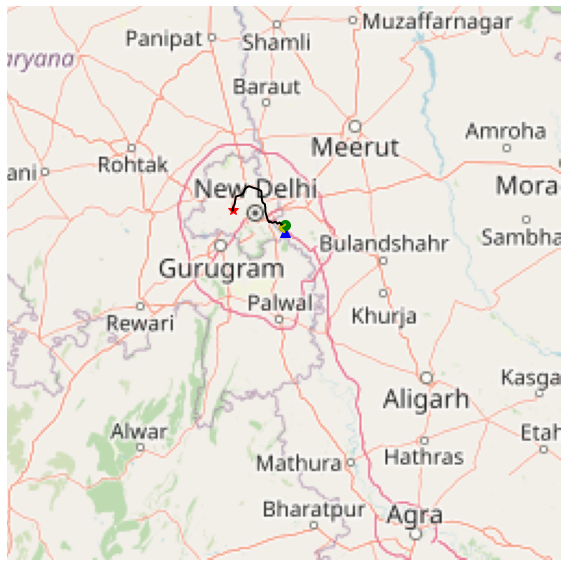

In [125]:
if(str.lower(refuel) == "yes"):
    ax = m.show_mpl(figsize=(8, 8))

    # Mark our positions.(Source->Station->Destination : RBG)
    # Source will be marked with '*' in red.
    ax.plot(a[0], b[0], 'or', ms=10, marker='*')
    
    if source_i != station_i:  # Station will not be printed if it is at the source point.
        ax.plot(a[-1], b[-1], 'ob', ms=10, marker='^')  # Station is marked with a ^ in blue.
        flag = True

    if station_i != destination_i and not flag :  # Station will not be printed if it is at the destination point
        ax.plot(x[0], y[0], 'ob', ms=10, marker='^')  # Charging station is marked with a ^ in blue.
    
    ax.plot(x[-1], y[-1], 'og', ms=10)            # Destination is marked with a . in green.

    # Mark the 2 paths, first from source to closest charging station and then from there on to the destination.
    if source_i != station_i:
        ax.plot(a, b, '-k', lw=2) # Source to station is marked with black.
    if station_i != destination_i:
        ax.plot(x, y, '-y', lw=2) # Station to destination is marked with yellow.

    # NOTE: If the black and yellow lines overlap, yellow will be seen.

Case 2(the user chooses not to refuel their vehicle and go to the destination directly instead) has been considered below

In [126]:
if(str.lower(refuel) == "no"):
    # Compute the shortest path from source to the destination.
    path = nx.shortest_path(
        sg,
        source=tuple(nodes[source_i]),
        target=tuple(nodes[destination_i]),
        weight='distance')  # Computes the shortest path (weighted by distance).

In [127]:
if(str.lower(refuel) == "no"):
    print("Source: ", nodes[source_i])
    print("Destination: ", nodes[destination_i])

In [128]:
if(str.lower(refuel) == "no"):
    linepath = get_full_path(path)
    x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

In [129]:
if(str.lower(refuel) == "no"):
    ax = m.show_mpl(figsize=(8, 8))
    ax.plot(x[0], y[0], 'or', ms=10, marker='*')
    ax.plot(x[-1], y[-1], 'og', ms=10)
    ax.plot(x, y, '-k', lw=2)

Check if there's a charging station close to the destination, so that the vehicle can be taken there instead and 
charged up, while the user can carry out whatever activity at their destination point.

In [130]:
# Check for a charging station within {threshold}km radius of the destination.
threshold = 1 # distance in km
if(dist4 <= threshold):
    # ask if the user wants to take their car to the station
    print("Do you want to take the car to a charging station nearby ?(YES or NO)")
    flag = input()
    if(str.lower(flag) == "no"):
        pass
    else:
        # plot the route from destination to station
        path_w = nx.shortest_path(
        sg,
        source=tuple(nodes[destination_i]),
        target=tuple(nodes[dest_station_i]),
        weight='distance')  # Computes the shortest path (weighted by distance).
        
        linepath_w = get_full_path(path_w)
        w1, w2 = m.to_pixels(linepath[:, 1], linepath[:, 0])
        
        ax_w = m.show_mpl(figsize=(8, 8))
        ax_w.plot(w1[0], w2[0], 'og', ms=10)
        ax_w.plot(w1[-1], w2[-1], 'om', ms=10, marker=',')
        ax_w.plot(w1, w2, '-c', lw=2)